This notebook is designed to implement the Quantile UCB algorithm imposed in [QuantUCB Construction](https://www.overleaf.com/read/dxfvfpqsdrcb).

Policy: Expectation + Quantile

Estimation method: Empirical quantile estimation + linear interpolation

Assumptions: normal distribution with known mean and variance, small and bounded KL divergence between quantile estimation and true quantile, strictly increasing and differentiable cdf 

In [1]:
from UCB_discrete import Environment, QuantUCB_Gau, UCB1

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import math
from scipy.stats import entropy

### Quantile Estimation Experiment

In [2]:
def emp_quant(alpha, data):
    """implement empirical quantile estimation. 
    
    Parameters
    -----------------------------------
    data: list
        sequence of sample rewards
    alpha: 
        level of quantile

    Return
    ------------------------------------
    quantile: float
        alpha level quantile of given data
    """
        
    data = np.sort(data)
    idx = int(len(data) * alpha)
    return data[idx]

def linear_inter_quant(alpha, data):
    """implement linear interpolation for quantile estimation.
    
    Parameters
    -----------------------------------
    data: list
        sequence of sample rewards
    alpha: 
        level of quantile

    Return
    ------------------------------------
    quantile: float
        alpha level quantile of given data
    """
    size = len(data) 
    data = list(data)
    data.append(0)
    data = np.sort(data)
    #data[-1] = 1
    s = int(alpha * size) 
    rate = (data[s + 1] - data[s]) * size
    #b = data[s] * (1-s) - data[s+1]
    #return rate * alpha + b
    return rate * (alpha - float(s)/size) + data[s]


### Test on normal distribution 

In [3]:
data = list(np.random.normal(0,1,5))

In [4]:
data

[0.2272897215986798,
 1.344749727550473,
 -0.2683491083899835,
 -1.3290629113668917,
 0.08645289019182867]

In [5]:
quantile = []
quantile_inter = []
qrange = np.arange(0,1,0.001)

for alpha in qrange:
    quantile.append(emp_quant(alpha, data))
    quantile_inter.append(linear_inter_quant(alpha, data))
    
#print(quantile)
#print(quantile_inter)
entropy(quantile_inter, np.sort(np.random.normal(0,1,1000)))

inf

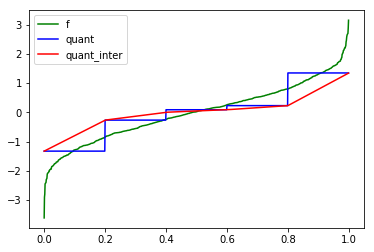

In [6]:
#plt.plot(x_axis,np.sort(data), 'yo', label = 'sample')
plt.plot(np.arange(0,1,0.001), np.sort(np.random.normal(0,1,1000)), 'g', label = 'f')
plt.plot(qrange, quantile, '-b',label = 'quant')
plt.plot(qrange, quantile_inter, '-r', label = 'quant_inter')
plt.legend()
plt.savefig('Quantile Estimation.png')

### Test on beta distribution

In [7]:
from scipy.stats import beta

a, b = 2, 5
data = list(beta.rvs(a,b,size = 5))

quantile = []
quantile_inter = []
qrange = np.arange(0,1,0.001)

for alpha in qrange:
    quantile.append(emp_quant(alpha, data))
    quantile_inter.append(linear_inter_quant(alpha, data))
    
#print(quantile)
#print(quantile_inter)
entropy(quantile_inter, beta.rvs(a, b, size=1000))

0.4393669093252662

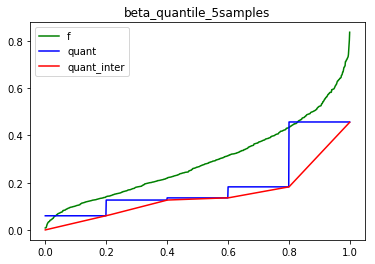

In [8]:

r= beta.rvs(a, b, size=1000)
plt.plot(np.arange(0,1,0.001), np.sort(r), 'g', label = 'f')
plt.plot(qrange, quantile, '-b',label = 'quant')
plt.plot(qrange, quantile_inter, '-r', label = 'quant_inter')
plt.title('beta_quantile_5samples')
plt.legend()
plt.savefig('beta_quantile_5samples')

### Quantile UCB with Gaussian rewards

In [15]:
env = [Environment(0,1,0), Environment(1,1,0)]
num_exper = 50
num_rounds = 5000
bestarm = 1

In [16]:
QuantUCB_regret = []
print('Simulate QuantUCB:')
for i in range(num_exper):
    QuantUCB_agent = QuantUCB_Gau(env, num_rounds, bestarm)
    regret = QuantUCB_agent.play()
    QuantUCB_regret.append(regret)
QuantUCB_regret = np.mean(np.asarray(QuantUCB_regret), axis = 0)

Simulate QuantUCB:


In [17]:
def regret_bound(t, env, bestarm):
    rb = 0
    for i in range(len(env)):
        mu_diff = env[bestarm].loc - env[i].loc
        if i != bestarm:
            rb += 32 * env[i].scale * np.log(t)/ mu_diff + (1 + np.pi ** 2/3.0) * mu_diff
    return rb

regret_bound_list = []
for i in range(num_rounds):
    if i >0:
        regret_bound_list.append(regret_bound(i, env, bestarm))

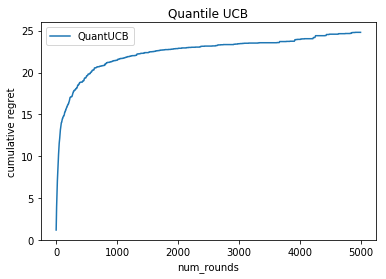

In [18]:
plt.plot(QuantUCB_regret, label = 'QuantUCB')
#plt.plot(np.log(regret_bound_list), label = 'bound')
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('Quantile UCB')
plt.legend()

### UCB1 with Gaussian rewards

In [13]:
UCB1_regret = []
for i in range(num_exper):
    UCB1_agent = UCB1(env, num_rounds, bestarm)
    regret = UCB1_agent.play()
    UCB1_regret.append(regret)
UCB1_regret = np.mean(np.asarray(UCB1_regret), axis = 0)

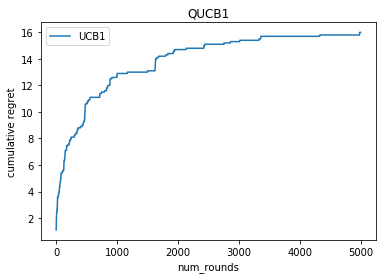

In [14]:
plt.plot(UCB1_regret, label = 'UCB1')
#plt.plot(np.log(regret_bound_list), label = 'bound')
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('QUCB1')
plt.legend()